# Energy consumption analysis and forcasting

## Setup

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns


plt.style.use('ggplot')


## Data

In [2]:
data = pd.read_csv('power_data.csv', index_col=[0], parse_dates=[0])
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)


### Duplicates

In [3]:
pd.concat(g for _, g in data.groupby("Datetime") if len(g) > 1)

,Power_MWH
Datetime,
2014-11-02 02:00:00,22935.0
2014-11-02 02:00:00,23755.0
2015-11-01 02:00:00,21567.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,20795.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,21236.0
2017-11-05 02:00:00,20666.0


In [4]:
data.shape

(75255, 1)

In [5]:
data = data.groupby(data.index).first()

In [6]:
[g for _, g in data.groupby("Datetime") if len(g) > 1]

[]

In [7]:
data.shape

(75251, 1)

### Filling missing values

In [8]:
data.isna().any().any()

False

Since its False, there are no missing values

## Analysis

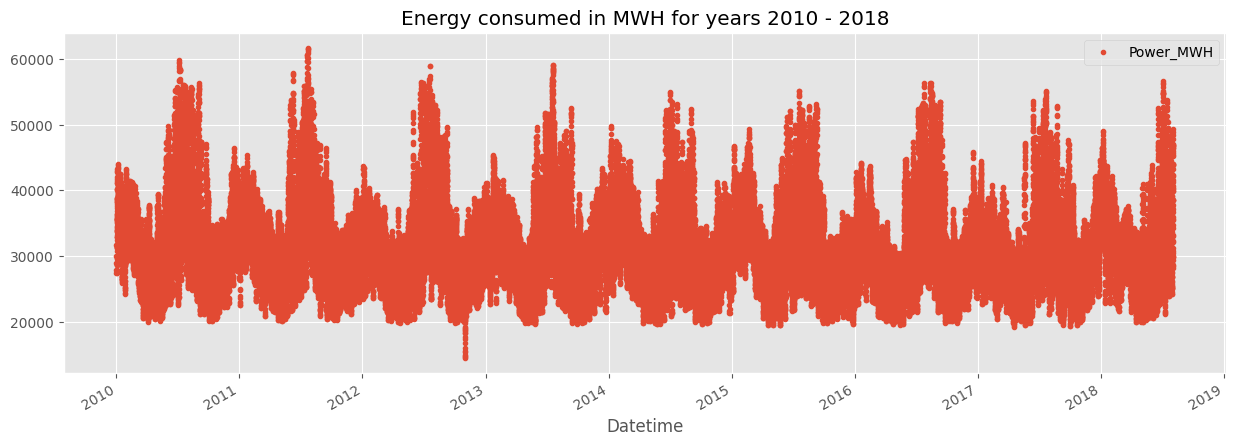

In [9]:
data.plot(style='.',
        figsize=(15, 5),
        title='Energy consumed in MWH for years 2010 - 2018')
plt.show()

We can observe anomalies just before 2013. It seems like there was a sudden decrease in energy consumption. While that is not noise, it can effect the performance of our model at predicting future consumption. Also, while it is reasonable to assume energy consumption will slowly increase as time passes, the data seems to have additive trend and additive seasonality.

### Feature engineering

In [10]:
# Took help from https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost/notebook
# https://towardsdatascience.com/time-series-analysis-7138ec68754a
# https://people.cs.pitt.edu/~milos/courses/cs3750/lectures/class16.pdf
def feature_engineering(df, label=None):
  
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = feature_engineering(data, label='Power_MWH')

features = pd.concat([X, y], axis=1)

In [11]:
# sns.pairplot(features,
#              hue='hour',
#              x_vars=['hour','dayofweek', 'quarter', 'month'],
#              y_vars='Power_MWH',
#              height=5,
#              plot_kws={'alpha':0.2, 'linewidth':0}
#             )
# plt.suptitle('Power_MWH by Hour, Day of Week, Quarter and Month')
# plt.show()


![Power consumption within a year](withinAYear.png)
*Figure 2*

Things to notice:
- As expected, energy consumption peaks between sunset till people go to sleep.
- Consumption is high on Friday and on higher levels even after 12 am on weekends as people stay up late.
- The quarter and montly graph show how much more energy is consumed during summers and reasonably so.

In [12]:

# sns.pairplot(features, 
#              hue='hour',
#              x_vars=[ 'year', 'dayofyear', 'dayofmonth','weekofyear'],
#              y_vars='Power_MWH',
#              height=5,
#              plot_kws={'alpha':0.15, 'linewidth':0}
#             )
# plt.suptitle('Power_MWH by Year, Day of Year, Day of Month and Week of Year')
# plt.show()

![Yearly power consumption](yearly.png)
*Figure 3*

### Data decomposition
Checking the trend, seasonal and residual component of our dataset

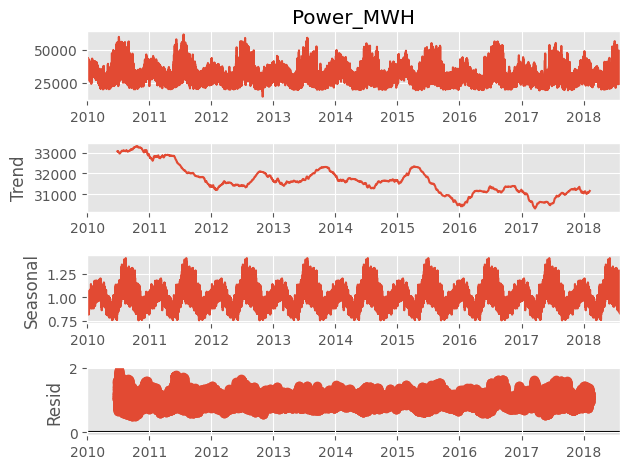

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Power_MWH'], model='multiplicative', period=24*356)
result.plot()
plt.show()



Performing the Dickey-Fuller test to check if data is in stationary form

In [14]:
from statsmodels.tsa.stattools import adfuller
fuller_test = adfuller(data)

print('D-F statistic = ' + str(fuller_test[0]))
print('p-value = ' + str(fuller_test[1]))
print('number of lags used = ' + str(fuller_test[2]))
print('Critical value at 5% confidence = ' + str(fuller_test[4]['5%']))
print('Critical value at 10% confidence = ' + str(fuller_test[4]['10%']))



if fuller_test[1] <= 0.05:             # p value needs to be <= 0.05
    print('Data is stationary.')
else:
    print('Data is not stationary.')

D-F statistic = -13.181226488347699
p-value = 1.1949146293295151e-24
number of lags used = 63
Critical value at 5% confidence = -2.8615784422349613
Critical value at 10% confidence = -2.5667904614808434
Data is stationary.


### Autocorrelation and Partial Autocorrelation

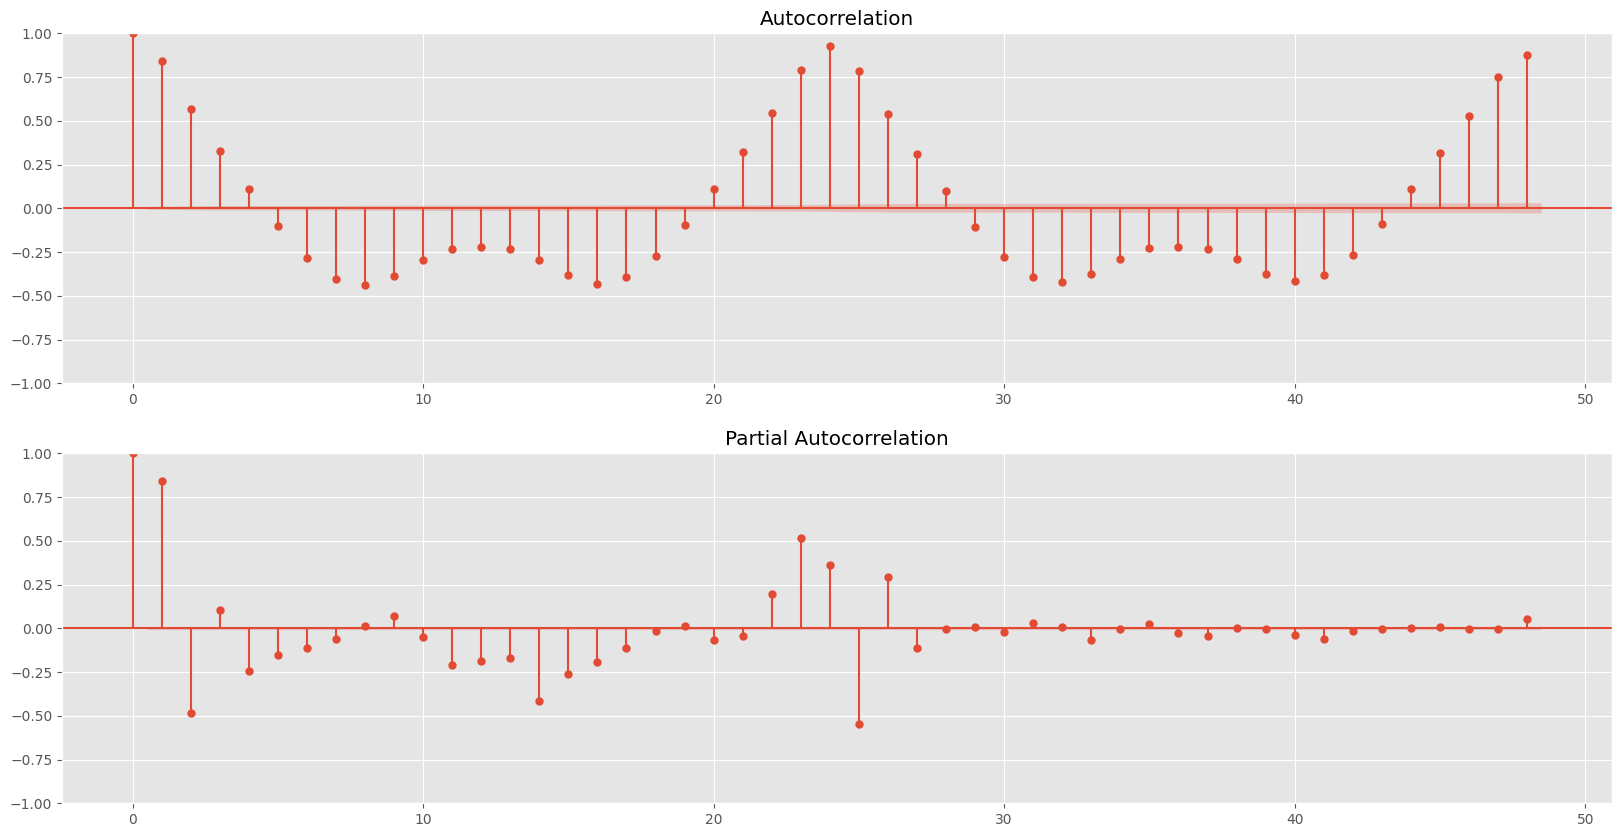

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf( data.diff().dropna(), lags=48, ax=ax[0])
plot_pacf(data.diff().dropna(), lags=48, ax=ax[1], method='ywm')
plt.show()


The repeating pattern every 24 lags suggests seasonality.

## Forecasting

In [16]:
# Data split
train = data.loc[data.index < '01-01-2014'].copy()
test = data.loc[data.index >= '01-01-2014'].copy()


### Time series baseline model: Persistence Algorithm

Baseline models are a great tool that allow engineers to build complex models. They function as benchmarks for trained models, highlight which areas of trained models need more tuning, give a good idea of the quality of dataset, and the information it represents. 

Most people agree that a baseline model should be:
- **Fast:** Easy to implement and get predictions on.
- **Simple:** Little to no intelligence or training.
- **Deterministic:** Gives the same result every time.

I chose to use the persistence model (naive forecast). It takes the value of the previous step to predict the outcome of the next step. I thought it was a good fit since it requires no training, its very simple to intrepret and understand, and its repeatable.

In [17]:
persistence_train = data[:'2013']
persistence_test = data['2014':]

persistence_forecast = data.shift(1)
persistence_prediction = persistence_forecast.loc[persistence_test.index, :]

In [18]:
mean_squared_error(persistence_test, persistence_prediction)

1868345.428152055

In [19]:
mean_absolute_error(persistence_test, persistence_prediction)

1060.7596775798586

In [20]:
# Mean Absolute Percentage Error (MAPE)
np.mean(np.abs((np.array(persistence_test) - np.array(persistence_prediction)) / np.array(persistence_test))) * 100

3.429696037534918

### Autoregression (AR)
This method predicts the outcome of the next step using a linear function on previous observations together with a random error in the same series. The number of past steps it will consider depends on the value we give it (p).

Pros:
- Requires less data.
- Predict recurring patterns.
- Autocorrelation function allows detecting lack of randomness in data.

Cons:
- Since its results are based purely on past information, it fails to account for new forces that might change future outcome.
- Effects of anomalies can be everlasting.

### Moving Average (MA)
It gives a value using a linear equation of the mean of the series, the present error term and past errors with their coefficients. Number of past errors considered depends on input (q).

Pros:
- Gives a smooth graph that is resistant to sudden changes.
- Always stationary.

Cons:
- Its resistant nature can be a weakness, espcially in areas where capturing and responsing to sudden changes is necessary.
- Harder parameter estimation than AR.


### Autoregressive Moving Average (ARMA)
This method uses both AR and MA to forecast timeseries data. It is a stationary model, meaning the mean and variance of data doesnt change over time. Its input is (p, q) for AR and MA.

Pros:
- High-resolution method that performs better than AR or MA.
- Great performance for their simple and explainable .nature
- Few hyperparameters to manage.


Cons:
- Finding optimal parameters can be a challange.
- Doesn't capture seasonality.
- Similar to AR/MA, it has exponential time complexity as it has to fit increased number of coefficients as p and q increase.
- Can have cases where data is too complex to handle.
- Requires large amount of data, especially if data is seasonal.


### Autoregressive Integrated Moving Average (ARIMA)
It only differs from ARMA in the Integrated part. If the data isnt stationary, we use ARIMA. We can use Differencing to make it stationary but there are other ways too like differencing, transformation, decomposition etc. Then, we can use dickey-fuller test to confirm stationarity. If data is already stationary, we can use ARMA. Its input are (p, d, q) where p and q are same as ARMA but d is for number of differencing needed to make data stationary.

Similar pros and cons to ARMA.


### Seasonal-ARIMA (SARIMA)
It is ARIMA but accounts for seasonality in its forecast causing it to be more robust. It requires a period input which is the period of time after which seasonality occurs. Its input are (p, d, q)(P, D, Q)m. Here, (p, d, q) are same as ARIMA, m is number of time steps for a single seasonal period and (P, D, Q) are the seasonall part similar to non-seasonal components , but involve backshifts of the seasonal period.

Similar pros and cons to ARMA but better for seasonal data.


### Extreme Gradient Boosting (XGBoost)
It works as Newton-Raphson in function space and is an implementation of gradient boosted decision trees.


Pros:
- Offers features like parallelization, distributed computing and GPU for training.
- Its extremely fast and adapts well to all types of data, even with missing values.
- Its easy to use, popular amoung researchers and well-documented.

Cons:
- Not good when number of training samples is smaller than number of features.
- For tasks like computer vision, NLP and image recognition, Deep learning gives better results.

### Facebook Prophet
Using the sum of its growth function, seasonality function, holidays function and error, it helps forecast timeseries data. Its an additive model that fits non-linear trends with yearly, weekly, and daily seasonality, plus holiday effects. Works best on series with seasonal effects and data through several seasons.

Pros:
- It handles missing values and anomalies well so they dont harm model accuracy.
- Fast and automatic setup allowing time for deeper manual analysis.
- The resulting model can be tuned to further improve accuracy.
- Its build to handle holiday effects and seasonality, accounting for the spikes during training. Plus, the decomposition makes it easy to interpret.

Cons:
- Finds best curve to fit data rather than look for casual relationships through time.
- In situations where prior assumptions dont fit, this model doesnt perform well as it doesnt consider recent data.
- Requires data in specific format.
- Adding more features is challenging.



I chose Facebook's Prophet for a couple of reasons:
- During analysis, I noticed how data followed these daily, weekly, monthly, and yearly cycles. This model incorporated these non-linear trends and allows for their decomposition, making data more interpretable.
- Its easy to set up and allowed me to do further analyze while giving decent results.
- It further allows addition of holiday effects, which would help improve accuracy as holidays and festivals are a major force in determining electricity consumption.
- We had several seasons of data as this model prefers.
- The dickey-fuller test showed that the data is stationary, making this model an ideal candidate.

### Facebook's Prophet procedure

In [21]:
# From paper "Forecasting at scale" By Sean J Taylor​​, Benjamin Letham​ September 27, 2017
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [22]:
prophet = Prophet()

prophet.fit(train.reset_index().rename(columns={'Datetime':'ds', 'Power_MWH':'y'}))

16:14:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = test.reset_index().rename(columns={'Datetime':'ds', 'Power_MWH':'y'}).drop(['y'], axis=1)

# predicting values
forecast = prophet.predict(future)

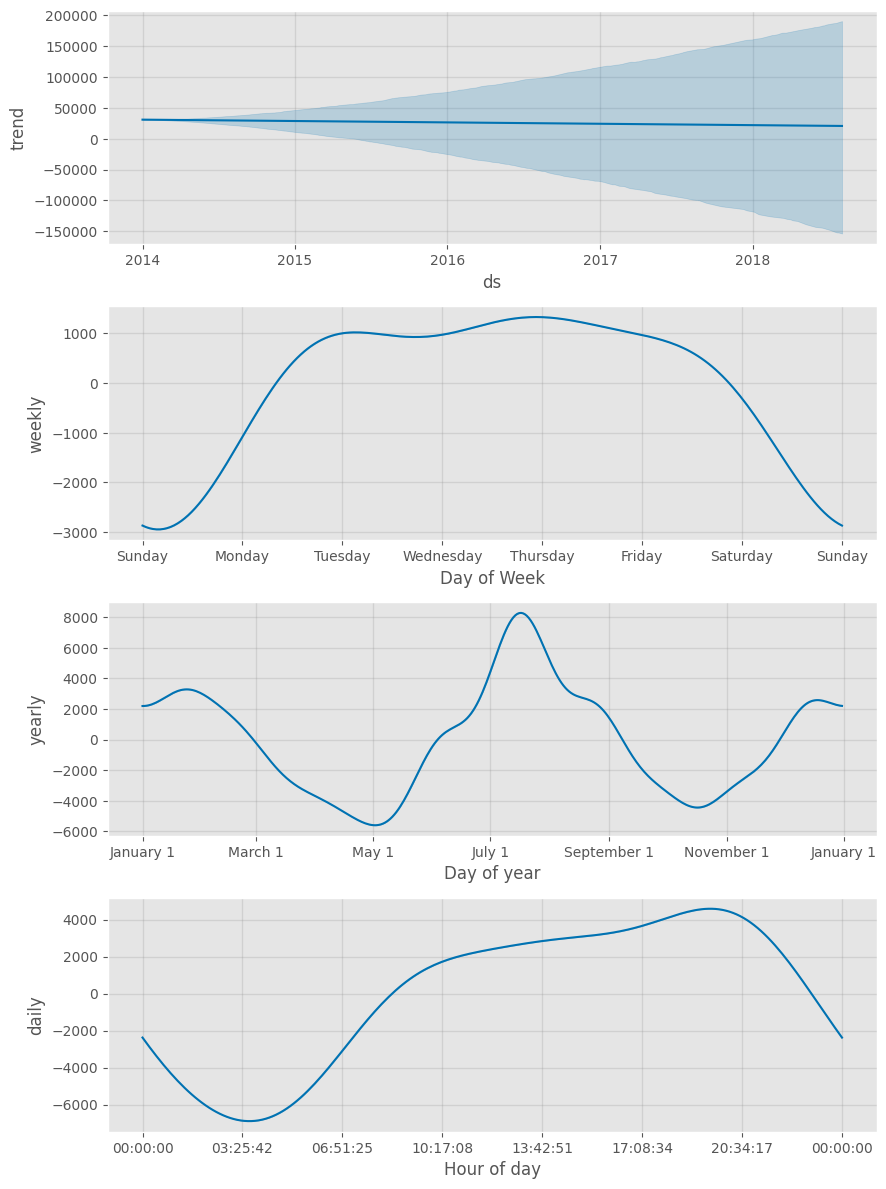

In [24]:
components = prophet.plot_components(forecast)

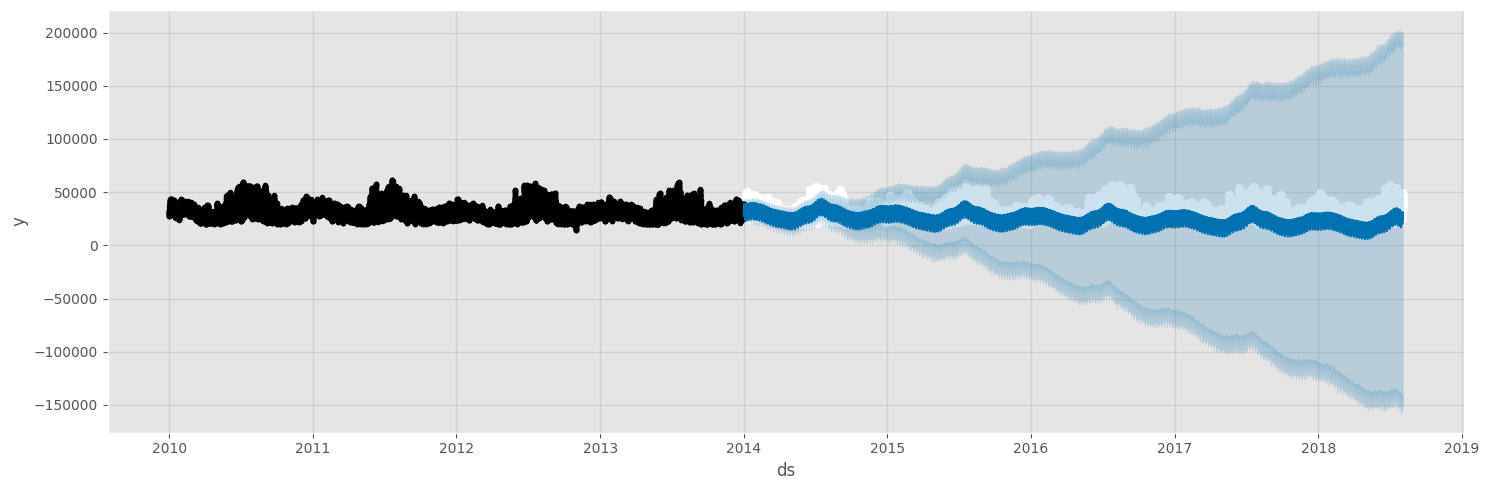

In [25]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['Power_MWH'], color='w')
fig = prophet.plot(forecast, ax=ax)

In [26]:
mean_squared_error(y_true=test['Power_MWH'],
                   y_pred=forecast['yhat'])

54255314.19244038

In [27]:
mean_absolute_error(y_true=test['Power_MWH'],
                   y_pred=forecast['yhat'])

5968.380082354989

In [28]:
# Mean Absolute Percentage Error (MAPE)
np.mean(np.abs((np.array(test['Power_MWH']) - np.array(forecast['yhat'])) / np.array(test['Power_MWH']))) * 100

18.82200047233949

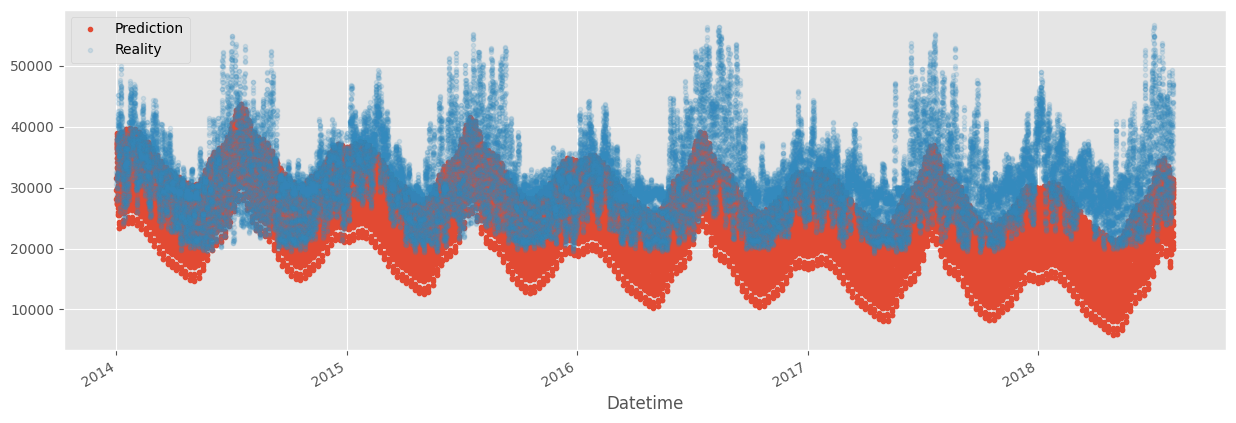

In [29]:
ax = forecast.set_index('ds')['yhat'].plot(figsize=(15, 5), style='.')
test['Power_MWH'].plot(ax=ax, style='.', alpha=0.15)
plt.legend(['Prediction','Reality'])
plt.show()